<a href="https://colab.research.google.com/github/sulochandhungel/ReferenceET/blob/master/Comparison_AgriMet_and_NLDAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import ee
# Trigger the authentication flow.
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Rf3TopMCzH4ZFLjcmOcZipIbBQNmqlRoLlqeFZJf1sc&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/ygE8L3XqaG2ALW32gNcg3C3wzVGbG5MZa6vQuMBJfFnnI2viayfkZt8

Successfully saved authorization token.


In [49]:
# Import Earth Engine
import ee

try:
    ee.Initialize()
    print('The Earth Engine package initialized successfully!')
except ee.EEException as e:
    print('The Earth Engine package failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

The Earth Engine package initialized successfully!


In [50]:
import subprocess

try:
    import timezonefinder
except ImportError:
    print('timezonefinder package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'timezonefinder'])
print ("Done!")

Done!


In [66]:
# Function to get NLDAS data
def getNLDAS_data_GMT(reqd_area, GMTyear_, GMTmonth_, GMTday_, GMThour_, GMTminute_, GMTsecond_, var_name, resample_to_elev = True):
    import datetime
    import ee
    ee.Initialize()
    
    def getRH(temp, elev, q):
        pair = elev.expression('101.3 * pow((293 - 0.0065 * b()) / 293, 5.26)')
        es = temp.expression('0.6108 * exp(17.27 * b() / (b() + 237.3))')
        ea = pair.expression('q * pair / (0.622 + 0.378 * q)', {'pair':pair, 'q':q})
        return (ea.divide(es).multiply(ee.Image.constant(100.0)))
    
    selDT = datetime.datetime(GMTyear_, GMTmonth_, GMTday_, GMThour_, GMTminute_, GMTsecond_)
    endDT = (selDT + datetime.timedelta(days=1))
    
    if GMTminute_>=30:
        GMThour_ = GMThour_ + 1
    
    nldas_coll = ee.ImageCollection('FORA0125_H002').filterDate(selDT.strftime('%Y-%m-%d'), endDT.strftime('%Y-%m-%d')).filterBounds(reqd_area.geometry()).filter(ee.Filter.eq('start_hour', GMThour_))
    nldas_img = ee.Image(nldas_coll.first())
    
    rd = ee.Image('USGS/NED').projection() # Getting the data to the highest possible resolution of 10m
    ans_img_coarse = nldas_img.select(var_name).clip(reqd_area.geometry())
    
    if resample_to_elev:
        ans_img = nldas_img.select(var_name).resample('bilinear').reproject(rd).clip(reqd_area.geometry())
    else:
        ans_img = ans_img_coarse
    
    if var_name == "shortwave_radiation":
        ans_img = ans_img.divide(ee.Image.constant(1000.0)) # Get solar radiation in kW m-2 (Slr_Kw_Avg)
        ans_img_coarse = ans_img_coarse.divide(ee.Image.constant(1000.0))
        
    if var_name == "relative_humidity":
        temp = nldas_img.select('temperature')
        elev = ee.Image('USGS/NED')
        q = nldas_img.select('specific_humidity')
        ans_img_coarse = getRH(temp, elev, q).clip(reqd_area.geometry())
        if resample_to_elev:
            ans_img = getRH(temp, elev, q).resample('bilinear').reproject(rd).clip(reqd_area.geometry())
        else:
            ans_img = ans_img_coarse

    
    if var_name == "windspeed":
        wind_u = nldas_img.select("wind_u")
        wind_v = nldas_img.select("wind_v")
        uz = ((wind_u.pow(2)).add(wind_v.pow(2))).sqrt().clip(reqd_area.geometry())
        zw = ee.Image.constant(10) # wind speed measured at 10 m
        ans_img_coarse = uz.expression('uz * 4.87 / log(67.8 * zw - 5.42)', {'uz':uz, 'zw':zw})
        if resample_to_elev:
            uz = ((wind_u.pow(2)).add(wind_v.pow(2))).sqrt().resample('bilinear').reproject(rd).clip(reqd_area.geometry())
            ans_img = uz.expression('uz * 4.87 / log(67.8 * zw - 5.42)', {'uz':uz, 'zw':zw})
        else:
            ans_img = ans_img_coarse
        
    return ({'ans_img':ans_img,\
             'mean_val':list(ans_img_coarse.reduceRegion(ee.Reducer.mean(), reqd_area.geometry()).getInfo().values())[0]})
#print ("Done!")

def getNLDAS_data(reqd_area, year_ = 2015, month_ = 5, day_ = 13,
                   hour_ = 11, minute_ = 45, second_ = 11, var_name = 'shortwave_radiation', resample_to_elev = True):
    import pandas as pd
    from datetime import datetime
    from pytz import timezone

    from timezonefinder import TimezoneFinder

    tf = TimezoneFinder()
    import pytz

    reqd_area_cent = reqd_area.centroid().getInfo().get('geometry').get('coordinates')
    #print (reqd_area_cent)
    tz = pytz.timezone(str(tf.timezone_at(lng = reqd_area_cent[0], lat = reqd_area_cent[1])))

    #gmt_DT = datetime(im_year, im_month, im_day, im_hour, im_minute, im_second)
    loc_DT = datetime(year_, month_, day_, hour_, minute_, second_)
    tzoffset = tz.utcoffset(loc_DT, is_dst=True)
    #print (tzoffset)
    gmt_DT = loc_DT - tzoffset
    #print (gmt_DT)
    #print (loc_DT)
    #loc_DT = gmt_DT + tzoffset
    
    return (getNLDAS_data_GMT(reqd_area = reqd_area, GMTyear_ = gmt_DT.year, GMTmonth_ = gmt_DT.month, GMTday_ = gmt_DT.day,
                   GMThour_ = gmt_DT.hour, GMTminute_ = gmt_DT.minute, GMTsecond_ = gmt_DT.second, var_name = var_name, resample_to_elev = resample_to_elev))

#xx = getNLDAS_data_GMT(reqd_area = reqd_area, GMTyear_ = 2015, GMTmonth_ = 5, GMTday_ = 13,
#                   GMThour_ = 11, GMTminute_ = 45, GMTsecond_ = 11, var_name = 'relative_humidity', resample_to_elev = True)

print (" --- Checking NLDAS data acquistion ----- ")
#Location of HRHW Agrimet
lng = -120.57444
lat = 46.38472
buff_dist = 1*1000
loc_reqd = ee.Feature(ee.Geometry.Point(lng, lat))
reqd_area = loc_reqd.buffer(buff_dist)

xx = getNLDAS_data(reqd_area= reqd_area, year_ = 2015, month_ = 5, day_ = 13,\
                  hour_ = 11, minute_ = 45, second_ = 11,\
                  var_name = 'shortwave_radiation', resample_to_elev = True)
print (xx)
#getNLDAS_data()
print ("Done!")


 --- Checking NLDAS data acquistion ----- 
{'ans_img': <ee.image.Image object at 0x7f42b84e7748>, 'mean_val': 0.38631299999999996}
Done!


In [67]:
import datetime
DTs = ["2016-04-08 11:43:18", "2016-04-16 11:45:58", "2016-05-02 11:46:04",\
           "2016-05-10 11:43:14", "2016-05-18 11:46:05", "2016-06-19 11:46:14"]
echoans = False

print (DTs)
#pd.to_datetime(DTs, format = '%Y-%m-%d %H:%M:%S').rename("TIMESTAMP")
loc_DTs = [datetime.datetime.strptime(loc_DT, "%Y-%m-%d %H:%M:%S") for loc_DT in DTs] 
#DateTime.year

['2016-04-08 11:43:18', '2016-04-16 11:45:58', '2016-05-02 11:46:04', '2016-05-10 11:43:14', '2016-05-18 11:46:05', '2016-06-19 11:46:14']


In [68]:
#Get a dataframe of NLDAS data mean
import pandas as pd
import numpy as np
w_data_type = "NLDAS"

if w_data_type == "NLDAS":
    #DateTime = pd.to_datetime(Sat_DTs_CldCov['Date'] , format = '%Y-%m-%d %H:%M:%S').rename('TIMESTAMP')
    DateTime = pd.to_datetime(DTs, format = '%Y-%m-%d %H:%M:%S').rename('TIMESTAMP')
    
    records = pd.DataFrame(range(1, (DateTime.size)+1), columns= ['RECORD'])
    years = DateTime.year.rename('Year')
    months = DateTime.month.rename('Month')
    days = DateTime.day.rename('Day')
    hours = DateTime.hour.rename('Hour')
    minutes = DateTime.minute.rename('Minute')
    seconds = DateTime.second.rename('Second')
    
    
    ws_ms_avg = []
    winddir = []
    slrkw_avg = []
    airtc_avg = []
    rh = []
    rainmmtot  = []
    
    for i in range(0,len(DateTime)):
        print (DateTime[i])
        def NLDAS_common(var_name, reqd_area = reqd_area, echoans = echoans):
            ans = getNLDAS_data(reqd_area, year_ = years[i],
                                month_ = months[i],
                                day_ = days[i],
                                hour_ = hours[i],
                                minute_ = minutes[i],
                                second_ = seconds[i],
                                var_name = var_name, resample_to_elev = True).get('mean_val')
            if echoans:
              print (var_name + " = " + str(ans))
            return (ans)
    
        ws_ms_avg.append(NLDAS_common('windspeed'))
        winddir.append(None)
        slrkw_avg.append(NLDAS_common('shortwave_radiation'))
        airtc_avg.append(NLDAS_common('temperature'))
        rh.append(NLDAS_common('relative_humidity'))
        rainmmtot.append(NLDAS_common('total_precipitation'))
    

    list_of_series = [DateTime,
                      pd.Series(years), pd.Series(months), pd.Series(days),
                      pd.Series(hours), pd.Series(minutes), pd.Series(seconds),
                      pd.Series(ws_ms_avg).rename('WS_ms_Avg'),
                      pd.Series(winddir).rename('WindDir'),
                      pd.Series(slrkw_avg).rename('SlrkW_Avg'),
                      pd.Series(airtc_avg).rename('AirTC_Avg'),
                      pd.Series(rh).rename('RH'),
                      pd.Series(rainmmtot).rename('Rain_mm_Tot')]

    hourly_data = None
    for ser in list_of_series:
        if hourly_data is None:
            hourly_data = pd.DataFrame(ser)
        else:
            hourly_data = pd.concat([hourly_data, ser], axis=1)
    hourly_data = hourly_data.reset_index(drop=True)
    hourly_data = pd.concat([hourly_data, records], axis=1)

    # Create a complete dataframe for all the variables
    w_df = pd.DataFrame().reindex_like(hourly_data).iloc[0:len(loc_DTs)]
    w_df['TIMESTAMP'] = loc_DTs

    w_df1 = pd.concat([hourly_data, w_df]).sort_values(by=['TIMESTAMP']).reset_index(drop=True)
    indsNaNs =  (w_df1[w_df1['RECORD'].isnull()].index) # only those datetimes are interpolated for Satellite datetimes
    #indsNaNs =  (w_df1[w_df1.isnull().any(axis=1)].index) # all NaNs are interpolated 
    #print (indsNaNs)

    w_df1 = w_df1.replace(-9999.000000, np.nan)
    w_df_interp = w_df1.interpolate('linear')

    w_df_4_Sat_DT_NLDAS = w_df_interp.iloc[indsNaNs]
    w_df_4_Sat_DT = w_df_4_Sat_DT_NLDAS
    
    
    print (w_df_4_Sat_DT)
print ("Done!")
#print (DateTime)


2016-04-08 11:43:18
2016-04-16 11:45:58
2016-05-02 11:46:04
2016-05-10 11:43:14
2016-05-18 11:46:05
2016-06-19 11:46:14
             TIMESTAMP    Year  Month  ...         RH  Rain_mm_Tot  RECORD
1  2016-04-08 11:43:18  2016.0    4.0  ...  46.089918          0.0     1.5
3  2016-04-16 11:45:58  2016.0    4.5  ...  42.101539          0.0     2.5
5  2016-05-02 11:46:04  2016.0    5.0  ...  37.435647          0.0     3.5
7  2016-05-10 11:43:14  2016.0    5.0  ...  38.116897          0.0     4.5
9  2016-05-18 11:46:05  2016.0    5.5  ...  37.695355          0.0     5.5
11 2016-06-19 11:46:14  2016.0    6.0  ...  34.710139          0.0     6.0

[6 rows x 14 columns]
Done!


In [69]:
# Function to get AgriMet data
#Create a dataframe with day of satellite image day
import pandas as pd
import numpy as np
import requests
from io import StringIO

def getAgriMetdata(StnID, styr, stmon, stday,
                   enyr=None, enmon=None, enday=None,
                   ):
    if enyr is None:
        enyr = styr
    if enmon is None:
        enmon = stmon
    if enday is None:
        enday = stday
    #"pn-bin/webdaycsv.pl?"+\ # This stopped working
    Dataurl = "https://www.usbr.gov/"+\
    "pn-bin/instant.pl?"+\
    "station="+ StnID +\
    "&year=" + str(styr) +\
    "&month=" + str(stmon) +\
    "&day="+ str(stday) +\
    "&year="+ str(enyr) +\
    "&month="+ str(enmon) +\
    "&day="+ str(enday) +\
    "&pcode=" + "OB" +\
    "&pcode=" + "TU" +\
    "&pcode=" + "WS" +\
    "&pcode=" + "WD" +\
    "&pcode=" + "SI" +\
    "&pcode=" + "EA" +\
    "&pcode=" + "PC" +\
    "&pcode=" + "TP" +\
    "&pcode=" + "SL" +\
    "&pcode=" + "EH"


    #url = "https://www.usbr.gov/pn-bin/instant.pl?list=boii%20ob,boii%20obx&start=2016-04-15&end=2016-04-20"
    headers = {"User-Agent":
               "Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
                AppleWebKit/537.36 (KHTML, like Gecko) \
                Chrome/80.0.3987.163 Safari/537.36"}
    req = requests.get(Dataurl, headers=headers)
    Datalink = StringIO(req.text)
    #print (Datalink)
    
    df = pd.read_csv(Datalink, skiprows= 20, error_bad_lines=False, delim_whitespace=False) # with the new Agrimet data table, this has been changed
    #print (df.head(2))
    df.drop(df.tail(3).index,inplace=True)

    return df
print ("Done!")
StnID = "HRHW"
styr = 2015
stmon = 5
stday = 5
tt = getAgriMetdata(StnID, styr, stmon, stday)

Done!


In [70]:
loc_DTs = [datetime.datetime.strptime(loc_DT, "%Y-%m-%d %H:%M:%S") for loc_DT in DTs] 

k = 0
j = 0
if k == 0:
  if j ==0:
    result = None
    for DT in loc_DTs:
        if result is None:
            result = getAgriMetdata(StnID, DT.year, DT.month, DT.day)
            #result['PC'][0] = 0.0
            #result['PC'] = result['PC'][1:96] - result['PC'][0:95] 
        else:
            result2 = getAgriMetdata(StnID, DT.year, DT.month, DT.day)
            #result2['PC'][0] = 0.0
            #result2['PC'] = result2['PC'][1:96] - result2['PC'][0:95] 
            result = pd.concat([result, result2])
    
    for i in range(0, len(result.keys())):
        if ('WS' in result.keys()[i]) and (StnID.upper() in result.keys()[i]):
            WS_varid = result.keys()[i]
        if 'WD' in result.keys()[i] and (StnID.upper() in result.keys()[i]):
            WD_varid = result.keys()[i]
        if (('SI' in result.keys()[i]) and (not 'SI2' in result.keys()[i]) and\
            (StnID.upper() in result.keys()[i])):
            SI_varid = result.keys()[i]
        if 'TU' in result.keys()[i] and (StnID.upper() in result.keys()[i]):
            TU_varid = result.keys()[i]
        if 'PC' in result.keys()[i] and (StnID.upper() in result.keys()[i]):
            PC_varid = result.keys()[i]
        if (('OB' in result.keys()[i]) and (StnID.upper() in result.keys()[i])):
            OB_varid = result.keys()[i]
    
    DT_strname_in_table = result.iloc[1].index[0]
    #print (DT_strname_in_table)
    DateTime = pd.to_datetime((result[DT_strname_in_table]), format = '%m/%d/%Y %H:%M').rename('TIMESTAMP')
    records = pd.DataFrame(range(1, (DateTime.size)+1), columns= ['RECORD'])
    #records = pd.Series([range(1, (DateTime.size+1))]).rename('RECORD').reset_index(drop=True)
    #hourly_data1 = pd.concat([result, DateTime], axis=1).reset_index(drop=True)
    #hour_data = pd.concat([hourly_data1, records], axis=1)
    
    #print (result.keys())

    years = DateTime.dt.year.rename('Year')
    months = DateTime.dt.month.rename('Month')
    days = DateTime.dt.day.rename('Day')
    hours = DateTime.dt.hour.rename('Hour')
    minutes = DateTime.dt.minute.rename('Minute')
    seconds = DateTime.dt.second.rename('Second')

    ws_ms_avg = result[WS_varid]
    winddir = result[WD_varid]
    slrkw_avg = result[SI_varid]
    airtc_avg = result[OB_varid]
    rh = result[TU_varid]
    rainmmtot = result[PC_varid]

    #print (slrkw_avg * 1.0)
    xx = slrkw_avg.apply(pd.to_numeric)
    
    #print ("All rows numeric?")
    #print (result.applymap(np.isreal).all(axis = 0))
    #print (type(rh))
    
    print ("Forcing to nan if not numeric...")
    rh = (rh.apply(pd.to_numeric, errors='coerce')).rename('RH')
    ws_ms_avg = ((ws_ms_avg.apply(pd.to_numeric, errors='coerce')) * 0.44704).rename('WS_ms_Avg')
    winddir = (winddir.apply(pd.to_numeric, errors='coerce')).rename('WindDir')
    slrkw_avg = (((slrkw_avg.apply(pd.to_numeric, errors='coerce'))) * (41868.0 / (1000.0 * 3600.0))).rename('SlrkW_Avg')
    airtc_avg = (((airtc_avg.apply(pd.to_numeric, errors='coerce'))-32.0) * (5/9.0)).rename('AirTC_Avg')
    rainmmtot = (rainmmtot.apply(pd.to_numeric, errors='coerce') * 25.4).rename('Rain_mm_Tot')
    
    list_of_series = [DateTime, years, months, days, hours, minutes, seconds,
                     ws_ms_avg, winddir, slrkw_avg, airtc_avg, rh, rainmmtot]
    hourly_data = None
    for ser in list_of_series:
        if hourly_data is None:
            hourly_data = pd.DataFrame(ser)
        else:
            hourly_data = pd.concat([hourly_data, ser], axis=1)
    hourly_data = hourly_data.reset_index(drop=True)
    hourly_data = pd.concat([hourly_data, records], axis=1)
    #print (hourly_data)

    # Create a complete dataframe for all the variables
    w_df = pd.DataFrame().reindex_like(hourly_data).iloc[0:len(loc_DTs)]
    w_df['TIMESTAMP'] = loc_DTs

    w_df1 = pd.concat([hourly_data, w_df]).sort_values(by=['TIMESTAMP']).reset_index(drop=True)
    indsNaNs =  (w_df1[w_df1['RECORD'].isnull()].index) # only those datetimes are interpolated for Satellite datetimes
    #indsNaNs =  (w_df1[w_df1.isnull().any(axis=1)].index) # all NaNs are interpolated 
    #print (indsNaNs)

    w_df1 = w_df1.replace(-9999.000000, np.nan)
    w_df_interp = w_df1.interpolate('linear')

    w_df_4_Sat_DT_agrimet = w_df_interp.iloc[indsNaNs]
    w_df_4_Sat_DT = w_df_4_Sat_DT_agrimet
    #st_date_for_daily = loc_DTs[0] - timedelta(days=60)
    #en_date_for_daily = loc_DTs[len(loc_DTs)-1]

w_df_4_Sat_DT

Forcing to nan if not numeric...


,TIMESTAMP,Year,Month,Day,Hour,Minute,Second,WS_ms_Avg,WindDir,SlrkW_Avg,AirTC_Avg,RH,Rain_mm_Tot,RECORD
47,2016-04-08 11:43:18,2016.0,4.0,8.0,11.0,37.5,0.0,1.401470,117.00,0.702917,23.136111,34.535,472.694,47.5
143,2016-04-16 11:45:58,2016.0,4.0,16.0,11.5,22.5,0.0,1.718869,122.90,0.738563,15.330556,50.390,476.504,142.5
238,2016-05-02 11:46:04,2016.0,5.0,2.0,11.5,22.5,0.0,1.832864,165.10,0.795608,23.111111,35.540,476.504,236.5
332,2016-05-10 11:43:14,2016.0,5.0,10.0,11.0,37.5,0.0,2.344725,158.50,0.881089,19.697222,31.565,0.000,329.5
428,2016-05-18 11:46:05,2016.0,5.0,18.0,11.5,22.5,0.0,1.955800,136.30,0.887543,25.408333,38.770,20.066,424.5
523,2016-06-19 11:46:14,2016.0,6.0,19.0,11.5,22.5,0.0,2.013915,96.22,0.939297,19.136111,29.380,21.336,518.5


In [71]:
def plot_comp(w_df_4_Sat_DT_agrimet, w_df_4_Sat_DT_NLDAS, var):
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots()
  w_df_4_Sat_DT_agrimet.plot(x = "TIMESTAMP", y = var, ax = ax, style = "-*", label = 'Agrimet')
  w_df_4_Sat_DT_NLDAS.plot(x = "TIMESTAMP", y = var, ax= ax, style = "+-", label = 'NLDAS')
  plt.ylabel (var)
  return (0)
print ("Done!")

Done!


0

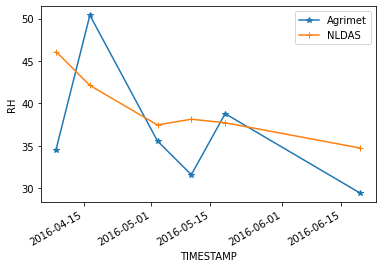

In [76]:
plot_comp(w_df_4_Sat_DT_agrimet, w_df_4_Sat_DT_NLDAS, var = "RH")

0

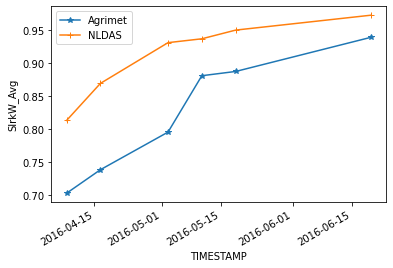

In [73]:
plot_comp(w_df_4_Sat_DT_agrimet, w_df_4_Sat_DT_NLDAS, var = "SlrkW_Avg")

0

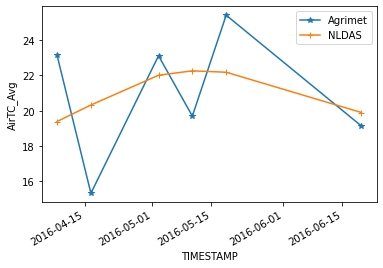

In [74]:
plot_comp(w_df_4_Sat_DT_agrimet, w_df_4_Sat_DT_NLDAS, var = "AirTC_Avg")

0

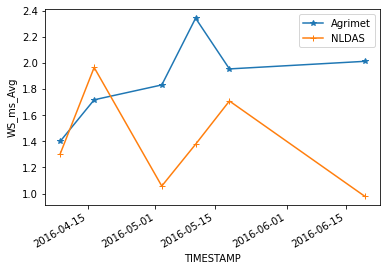

In [75]:
plot_comp(w_df_4_Sat_DT_agrimet, w_df_4_Sat_DT_NLDAS, var = "WS_ms_Avg")